<a href="https://colab.research.google.com/github/ranaurek/Quantum-Graph-Coloring/blob/main/Grover's_Algorithm_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qiskit

In [2]:
# Preamble
import qiskit
qiskit.__version__
from qiskit import *

from qiskit.visualization import plot_bloch_multivector, plot_histogram
import matplotlib.pyplot as plt


import numpy as np
from math import pi

%matplotlib inline

from IPython.display import Image ## For displaying Images

In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [4]:
def find_colorings(graph, nNodes, nColors, nShots):
    
    
    num_edges = 0 
    for key in graph:
        num_edges += len(graph[key])
        

    # Create a quantum circuit.
    q = QuantumRegister(nNodes*nColors)
    
    clauseQubits = QuantumRegister(nNodes+num_edges)
    
    outputQubit = QuantumRegister(1)

    c=ClassicalRegister(nColors*nNodes)
    qc = QuantumCircuit(q,clauseQubits,outputQubit,c)
    
    qc.initialize([1, -1]/np.sqrt(2), outputQubit)


    # Superposition the color qubits for each node.
    s=0
    for n in range(nNodes):
        s=nColors*n
        for k in range(nColors):
            qc.h(s+k)
            
    def apply_oracle():
        
        
        
        for n in range(nNodes):
            for k in range(nColors):
                qc.cx(q[2*n+k],clauseQubits[n])
                
        edgeCounter = nNodes-1;
        for origin in graph:
            for neighbor in graph[origin]:
                edgeCounter+=1
                print(origin,neighbor)
                for k in range(nColors):
                    qc.ccx(q[2*origin+k],q[2*neighbor+k],clauseQubits[edgeCounter])
                qc.x(clauseQubits[edgeCounter]);
                
        qc.mct(clauseQubits, outputQubit)
        
        for n in range(nNodes):
            for k in range(nColors):
                qc.cx(q[2*n+k],clauseQubits[n])
                
        edgeCounter = nNodes-1;
        
        
        for origin in graph:
            for neighbor in graph[origin]:
                edgeCounter+=1
                for k in range(nColors):
                    qc.ccx(q[2*origin+k],q[2*neighbor+k],clauseQubits[edgeCounter])
                qc.x(clauseQubits[edgeCounter]);
    

    
    
    
    
        qc.append(diffuser(nNodes+num_edges), [i for i in range(0,nNodes+num_edges)])
        
    
                
    apply_oracle()
    apply_oracle()
    
    # cb=nColors*nNodes-1
    for n in range(nNodes):
        # s=n*nColors
        for k in range(nColors):
            # qb=s+k
            qc.measure(q[2*n+k],c[2*n+k])
            # cb=cb-1

    # Execute the circuit on the qasm simulator.
    backend_sim = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend_sim, shots=nShots)
    # Grab the results from the job.
    result_sim = job.result()
    counts = result_sim.get_counts(qc)

    # Return results.
    return counts

def niceify(counts):
    nice_counts = {}
    for k,v in counts.items():
        nice_counts[",".join([k[nColors * i : nColors * i + nColors] for i in range(len(k) // nColors + 1)])] = v
    return nice_counts

In [ ]:
nNodes=3
nColors=2
graph = {
    0 : [1],
    1 : [2]
}

counts = find_colorings(graph, nNodes, nColors, 50)
print(niceify(counts))

0 1
1 2
0 1
1 2
{'00,01,11,': 1, '11,01,00,': 1, '11,10,11,': 1, '11,11,10,': 1, '11,11,01,': 1, '01,11,01,': 1, '10,01,10,': 15, '11,10,00,': 1, '10,10,00,': 1, '00,01,00,': 2, '01,10,10,': 1, '00,11,01,': 1, '01,10,01,': 21, '10,10,01,': 2}


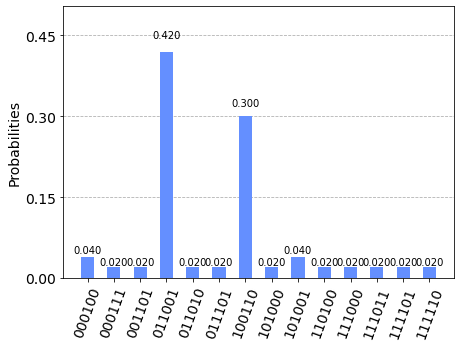

In [ ]:
plot_histogram(counts)